In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.spatial.distance import euclidean
from dtaidistance import dtw
from scipy.sparse import lil_matrix

import h5py
import networkx as nx
from collections import defaultdict

import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

from itertools import product
from torch_geometric.utils import add_self_loops

import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import random
from torch_geometric.utils import to_undirected

import torch.nn.init as init

In [2]:
class DatasetProcessor:
    def __init__(self, save_dir, seed=42, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
        self.save_dir = save_dir
        self.seed = seed
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio

        self.X = None
        self.Y = None
        self.merged_graphs = None  # 原始 NetworkX 图
        self.remapped_graphs = None  # 经过索引映射后的图

        self.X_train, self.Y_train = None, None
        self.X_val, self.Y_val = None, None
        self.X_test, self.Y_test = None, None

        self.test_norm_params = []

    def load_data(self):
        X_path = os.path.join(self.save_dir, "X.npy")
        Y_path = os.path.join(self.save_dir, "Y.npy")

        self.X = np.load(X_path)
        self.Y = np.load(Y_path)

        print(f"✅ Loaded X.npy with shape: {self.X.shape}")
        print(f"✅ Loaded Y.npy with shape: {self.Y.shape}")

        dtw_graphs_path = os.path.join(self.save_dir, "Merged_Gaussian_DTW_graphs.pkl")
        with open(dtw_graphs_path, 'rb') as f:
            self.merged_graphs = pickle.load(f)

        print(f"✅ Successfully loaded graph with {len(self.merged_graphs.nodes())} nodes and {len(self.merged_graphs.edges())} edges.")

        # ✅ 进行索引映射
        self.remapped_graphs = self.remap_graph_indices(self.merged_graphs)
        print(f"✅ Graph index remapping complete!")

    def remap_graph_indices(self, graph):
        """
        通过 nx.convert_node_labels_to_integers() 重新编号节点，确保索引连续从 0 开始。
        """
        remapped_graph = nx.convert_node_labels_to_integers(graph, ordering='sorted')
        print(f"✅ Remapped graph: {len(remapped_graph.nodes())} nodes, {len(remapped_graph.edges())} edges.")
        return remapped_graph

    def shuffle_and_split(self):
        num_samples = self.X.shape[0]
        num_train = int(num_samples * self.train_ratio)
        num_val = int(num_samples * self.val_ratio)
        num_test = num_samples - num_train - num_val

        indices = np.arange(num_samples)
        np.random.default_rng(self.seed).shuffle(indices)

        self.X = self.X[indices]
        self.Y = self.Y[indices]

        self.X_train, self.X_val, self.X_test = self.X[:num_train], self.X[num_train:num_train + num_val], self.X[num_train + num_val:]
        self.Y_train, self.Y_val, self.Y_test = self.Y[:num_train], self.Y[num_train:num_train + num_val], self.Y[num_train + num_val:]

        print(f"✅ Train dataset: {num_train} samples")
        print(f"✅ Val dataset: {num_val} samples")
        print(f"✅ Test dataset: {num_test} samples")

    @staticmethod
    def zscore_normalize(tensor):
        mean_val = tensor.mean()
        std_val = tensor.std()
        std_val = max(std_val, 1e-8)  # 避免除零问题
        normalized_tensor = (tensor - mean_val) / std_val
        return normalized_tensor, mean_val, std_val

    def apply_zscore_normalization(self):
        X_train_list, Y_train_list = [], []
        for x_win, y_win in zip(self.X_train, self.Y_train):
            x_norm, mean_val, std_val = self.zscore_normalize(torch.tensor(x_win, dtype=torch.float32))
            y_norm = (torch.tensor(y_win, dtype=torch.float32) - mean_val) / std_val
            X_train_list.append(x_norm)
            Y_train_list.append(y_norm)

        self.X_train = torch.stack(X_train_list)
        self.Y_train = torch.stack(Y_train_list)

        X_val_list, Y_val_list = [], []
        for x_win, y_win in zip(self.X_val, self.Y_val):
            x_norm, mean_val, std_val = self.zscore_normalize(torch.tensor(x_win, dtype=torch.float32))
            y_norm = (torch.tensor(y_win, dtype=torch.float32) - mean_val) / std_val
            X_val_list.append(x_norm)
            Y_val_list.append(y_norm)

        self.X_val = torch.stack(X_val_list)
        self.Y_val = torch.stack(Y_val_list)

        X_test_list, Y_test_list = [], []
        for x_win, y_win in zip(self.X_test, self.Y_test):
            x_norm, mean_val, std_val = self.zscore_normalize(torch.tensor(x_win, dtype=torch.float32))
            y_norm = torch.tensor(y_win, dtype=torch.float32)  # 测试集不归一化
            X_test_list.append(x_norm)
            Y_test_list.append(y_norm)

            self.test_norm_params.append({'mean': mean_val.item(), 'std': std_val.item()})

        self.X_test = torch.stack(X_test_list)
        self.Y_test = torch.stack(Y_test_list)

        print("✅ Applied Z-Score normalization.")

    def get_data(self):
        return self.X_train, self.Y_train, self.X_val, self.Y_val, self.X_test, self.Y_test, self.test_norm_params, self.remapped_graphs

In [3]:
save_dir = r"/root/autodl-tmp/data/Antwerp_2020_march"
    
processor = DatasetProcessor(save_dir)
processor.load_data()
processor.remap_graph_indices
processor.shuffle_and_split()
processor.apply_zscore_normalization()
    
X_train, Y_train, X_val, Y_val, X_test, Y_test, test_norm_params, remapped_graphs = processor.get_data()

# ✅ 创建 PyTorch 数据集
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

# ✅ 创建 DataLoader
batch_size = 16  # 可自行调整

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8) 

# ✅ 打印 DataLoader 信息
print(f"✅ Train DataLoader: {len(train_loader)} batches")
print(f"✅ Val DataLoader: {len(val_loader)} batches")
print(f"✅ Test DataLoader: {len(test_loader)} batches")
print(f"✅ number of graph nodes {remapped_graphs.number_of_nodes()}, number of graph edges {remapped_graphs.number_of_edges()}")

✅ Loaded X.npy with shape: (709, 6, 5524)
✅ Loaded Y.npy with shape: (709, 6, 5524)
✅ Successfully loaded graph with 5524 nodes and 90292 edges.
✅ Remapped graph: 5524 nodes, 90292 edges.
✅ Graph index remapping complete!
✅ Train dataset: 425 samples
✅ Val dataset: 141 samples
✅ Test dataset: 143 samples
✅ Applied Z-Score normalization.
✅ Train DataLoader: 27 batches
✅ Val DataLoader: 9 batches
✅ Test DataLoader: 9 batches
✅ number of graph nodes 5524, number of graph edges 90292


In [4]:
def merge_graphs_into_batch(merged_graphs, batch_size):
    """
    合并一个 batch 内的多张相同的图，返回合并后的 edge_index 和 edge_weight。

    参数:
        merged_graphs (nx.Graph): 需要合并的单张图，将其重复 batch_size 次
        batch_size (int): batch 内的图数量

    返回:
        edge_index_big (torch.Tensor): 合并后的边索引 (2, B*E)
        edge_weight_big (torch.Tensor): 合并后的边权重 (B*E,)
    """
    all_edge_indices = []
    all_edge_weights = []
    num_nodes_per_graph = len(merged_graphs.nodes)  # 获取单张图的节点数

    # 提取单张图的边索引和权重
    edge_list = list(merged_graphs.edges(data=True))  # [(u, v, {weight: w}), ...]
    edge_index = torch.tensor([[u, v] for u, v, _ in edge_list], dtype=torch.long).T  # (2, E)
    edge_weight = torch.tensor([data['final_weight'] for _, _, data in edge_list], dtype=torch.float32)  # (E,)

    # 复制 batch_size 份，并进行索引偏移
    for i in range(batch_size):
        offset = i * num_nodes_per_graph  # 计算节点索引偏移量
        edge_index_shifted = edge_index + offset  # 应用偏移，防止冲突
        
        all_edge_indices.append(edge_index_shifted)
    
    # 合并所有 edge_index
    edge_index_big = torch.cat(all_edge_indices, dim=1)  # (2, B*E)

    # 复制边权重 batch_size 次
    edge_weight_big = edge_weight.repeat(batch_size)  # (B*E,)

    return edge_index_big, edge_weight_big


In [5]:
edge_index_big, edge_weight_big = merge_graphs_into_batch(remapped_graphs, batch_size)

In [6]:
class GNNModule(nn.Module):
    def __init__(self, in_channels, out_channels, use_layernorm=False):
        super(GNNModule, self).__init__()
        self.gcn_layer = GCNConv(in_channels, out_channels)
        self.use_layernorm = use_layernorm
        if self.use_layernorm:
            self.gcn_norm = nn.LayerNorm(out_channels)

    def forward(self, x, edge_index_big, edge_weight_big):
        x = self.gcn_layer(x, edge_index_big, edge_weight_big)
        x = F.relu(x)
        if self.use_layernorm:
            x = self.gcn_norm(x)
        return x

In [7]:
class RNNModule(nn.Module):
    def __init__(self, rnn_type='RNN', input_dim=1, hidden_dims=[128, 256, 128, 1], dropout=0.2, use_layernorm=False):
        super(RNNModule, self).__init__()
        self.rnn_type = rnn_type.upper()
        self.use_layernorm = use_layernorm

        self.rnn_layers = nn.ModuleList()
        self.rnn_norms = nn.ModuleList()

        for hidden_dim in hidden_dims:
            if self.rnn_type == 'LSTM':
                rnn_layer = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
            elif self.rnn_type == 'GRU':
                rnn_layer = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
            elif self.rnn_type == 'RNN':
                rnn_layer = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
            else:
                raise ValueError(f"Unsupported RNN type: {self.rnn_type}")

            self.rnn_layers.append(rnn_layer)
            if self.use_layernorm:
                self.rnn_norms.append(nn.LayerNorm(hidden_dim))

            input_dim = hidden_dim  # 下一个 RNN 层的输入是前一层的输出

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: (B*N, T_rnn, 1)
        """
        rnn_out = x
        for idx, rnn_layer in enumerate(self.rnn_layers):
            rnn_out, _ = rnn_layer(rnn_out)
            if self.use_layernorm:
                rnn_out = self.rnn_norms[idx](rnn_out)
        rnn_out = self.dropout(rnn_out)

        return rnn_out  # (B*N, T_rnn, hidden_dim)

In [8]:
class GNN_RNN_Model(nn.Module):
    def __init__(self, gnn_in_channels=6, gnn_out_channels=6, rnn_type='RNN',
                 rnn_hidden_dims=[128, 256, 128, 1], rnn_dropout=0.2, use_layernorm=False, fc_hidden_dim=6):
        super(GNN_RNN_Model, self).__init__()

        self.gnn = GNNModule(gnn_in_channels, gnn_out_channels, use_layernorm)
        self.rnn = RNNModule(rnn_type, input_dim=1, hidden_dims=rnn_hidden_dims, dropout=rnn_dropout, use_layernorm=use_layernorm)
        self.fc_gnn = nn.Linear(gnn_out_channels, fc_hidden_dim)

    def forward(self, x, edge_index_big, edge_weight_big):
        """
        x: (B, T, N)  -> GNN
        """
        B, T, N = x.shape

        # ============ A) GNN 处理图结构 ============
        x_gnn = x.permute(0, 2, 1).reshape(B*N, T)  # (B*N, T)
        x_gnn = self.gnn(x_gnn, edge_index_big, edge_weight_big)  # GNN 输出: (B*N, gnn_out_channels)
        x_gnn = self.fc_gnn(x_gnn)  # (B*N, fc_hidden_dim)
        x_gnn = self.gnn(x_gnn, edge_index_big, edge_weight_big)  # GNN 输出: (B*N, gnn_out_channels)
        x_gnn = self.fc_gnn(x_gnn)  # (B*N, fc_hidden_dim)
        x_gnn = self.gnn(x_gnn, edge_index_big, edge_weight_big)  # GNN 输出: (B*N, gnn_out_channels)
        x_gnn = self.fc_gnn(x_gnn)  # (B*N, fc_hidden_dim)
        x_gnn = x_gnn.unsqueeze(-1)  # => (B*N, fc_hidden_dim, 1)

        # ============ B) RNN 处理时序 ============
        x_rnn = x.permute(0, 2, 1).contiguous().reshape(B*N, T, 1)
        rnn_out = self.rnn(x_rnn)  # => (B*N, T, 1)

        # ============ C) 结果（平均）拼接 ============
        # 确保 GNN 和 RNN 输出的形状相同
        assert x_gnn.shape == rnn_out.shape, f"Shape mismatch: x_gnn {x_gnn.shape}, rnn_out {rnn_out.shape}"

        # 拼接 GNN 和 RNN 输出 (B*N, 6, 1) → (B*N, 6, 1)
        x_GNN_RNN = torch.mean(torch.stack([x_gnn, rnn_out], dim=0), dim=0)  # (B*N, 6, 1)

        # ============ D) RNN处理 ============
        x_GNN_RNN_out = self.rnn(x_GNN_RNN)  # => (B*N, T, 1)
        GNN_RNN_out = x_GNN_RNN_out.reshape(B, N, 6, -1).permute(0, 2, 1, 3).reshape(B, 6, N)  # (B, 6, N)

        return GNN_RNN_out

In [9]:
# class GNN_RNN_Model(nn.Module):
#     def __init__(self, gnn_in_channels=8, gnn_out_channels=8, rnn_type='LSTM',
#                  rnn_hidden_dims=[128, 256, 128, 1], rnn_dropout=0.2, use_layernorm=True, fc_output_dim=1):
#         super(GNN_RNN_Model, self).__init__()

#         self.gnn = GNNModule(gnn_in_channels, gnn_out_channels, use_layernorm)
#         self.rnn = RNNModule(rnn_type, input_dim=1, hidden_dims=rnn_hidden_dims, dropout=rnn_dropout, use_layernorm=use_layernorm)
#         self.fc = nn.Linear(rnn_hidden_dims[-1], fc_output_dim)  # 预测层

#     def forward(self, x, edge_index_big, edge_weight_big):
#         """
#         x: (B, T, N)  -> GNN
#         """
#         B, T, N = x.shape
#         x_gnn = x.permute(0, 2, 1).reshape(B*N, T)  # (B*N, T)

#         # ============ A) GNN 处理图结构 ============

#         x_gnn = self.gnn(x_gnn, edge_index_big, edge_weight_big)  # GNN 输出: (B*N, gnn_out_channels)

#         # ============ B) RNN 处理时序 ============
#         rnn_in = x_gnn.view(B*N, self.gnn.gcn_layer.out_channels)  # (B*N, T_rnn)
#         rnn_in = rnn_in.unsqueeze(-1)  # => (B*N, T_rnn, 1)
#         rnn_out = self.rnn(rnn_in)  # => (B*N, T_rnn, hidden_dim)
#         rnn_out_last6 = rnn_out[:, -6:, :]  # 取最后 6 个时间步
#         rnn_out_last6 = rnn_out_last6.reshape(B, N, 6, -1).permute(0, 2, 1, 3).reshape(B, 6, N)  # (B, 6, N)

#         # # ============ C) 预测输出 ============
#         # rnn_out_last6 = rnn_out[:, -6:, :]  # 取最后 6 个时间步
#         # fc_out = self.fc(rnn_out_last6)  # (B*N, 6, fc_output_dim)
#         # fc_out = fc_out.view(B, N, 6, -1).permute(0, 2, 1, 3).squeeze(-1)  # (B, 6, N)

#         # return fc_out
#         return rnn_out_last6

In [10]:
def weights_init(m):
    if isinstance(m, nn.Linear):  # 仅初始化线性层
        init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)  # 通常 bias 初始化为 0

def train_model(
    model,
    train_loader,
    val_loader,
    edge_index_big,
    edge_weight_big,
    epochs=10,
    lr=0.0005,
    patience=5,            # 提前停止的耐心轮数
    lr_patience=3,         # 学习率调整的耐心轮数
    lr_factor=0.5,         # 学习率缩放因子
    min_lr=1e-6            # 学习率下限
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.apply(weights_init)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 学习率调度器（去掉 verbose=True）
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=lr_factor, patience=lr_patience, min_lr=min_lr
    )

    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    epochs_no_improve = 0

    edge_index_big = edge_index_big.to(device)
    if edge_weight_big is not None:
        edge_weight_big = edge_weight_big.to(device)

    for epoch in range(epochs):
        start_time = time.time()  # 开始计时
        # ============== 1. 训练 ==============
        model.train()
        total_train_loss = 0

        for X_batch, Y_batch in train_loader:

            current_batch_size = X_batch.shape[0]  # 获取当前 batch 的实际大小
            
            # 如果 batch size 小于设定的 batch_size，重新计算 edge_index_big
            if current_batch_size != batch_size:
                edge_index_big, edge_weight_big = merge_graphs_into_batch(remapped_graphs, current_batch_size)
                edge_index_big = edge_index_big.to(device)
                edge_weight_big = edge_weight_big.to(device)

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch, edge_index_big = edge_index_big, edge_weight_big = edge_weight_big)
            loss = criterion(preds, Y_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ============== 2. 验证 ==============
        model.eval()
        total_val_loss = 0

        edge_index_big = edge_index_big.to(device)
        if edge_weight_big is not None:
            edge_weight_big = edge_weight_big.to(device)
        
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:

                current_batch_size = X_batch.shape[0]  # 获取当前 batch 的实际大小

                # 如果 batch size 小于设定的 batch_size，重新计算 edge_index_big
                if current_batch_size != batch_size:
                    edge_index_big, edge_weight_big = merge_graphs_into_batch(remapped_graphs, current_batch_size)
                    edge_index_big = edge_index_big.to(device)
                    edge_weight_big = edge_weight_big.to(device)
                
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                val_preds = model(X_batch, edge_index_big = edge_index_big, edge_weight_big = edge_weight_big)
                val_loss = criterion(val_preds, Y_batch)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # ============== 3. 学习率调整 ==============
        scheduler.step(avg_val_loss)

        # ============== 4. 早停机制 ==============
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # 保存最佳模型
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_state)  # 恢复到最佳模型
                break

        # ============== 5. 输出每轮训练情况 ==============
        epoch_time = time.time() - start_time  # 计算本轮训练时间
        current_lr = scheduler.get_last_lr()[0]  # 使用 get_last_lr()
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.6e}, Time: {epoch_time:.2f}s")

    # # ============== 6. 测试集评估 ==============
    # model.eval()
    # total_test_loss = 0
    # with torch.no_grad():
    #     for X_test, Y_test in test_loader:
    #         X_test = X_test.to(device)
    #         Y_test = Y_test.to(device)

    #         test_preds = model(X_test,edge_index_single = edge_index, edge_weight_single=edge_weight)  # => (B,T,N)
    #         test_loss = criterion(test_preds, Y_test)
    #         total_test_loss += test_loss.item()

    # avg_test_loss = total_test_loss / len(test_loader)
    # print(f"\nFinal Test Loss: {avg_test_loss:.6f}")

    # ============== 7. 绘制损失曲线 ==============
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig("/root/autodl-tmp/model/Antwerp_2020_march/Static_dtw_Gaussian_Model_RNN-Encoder-Decoder/Training and Validation Loss.png")

    plt.close()

    return train_losses, val_losses

Epoch [1/300] - Train Loss: 1.519510, Val Loss: 1.389833, LR: 5.000000e-04, Time: 6.46s
Epoch [2/300] - Train Loss: 1.375015, Val Loss: 1.358817, LR: 5.000000e-04, Time: 6.37s
Epoch [3/300] - Train Loss: 1.360891, Val Loss: 1.366944, LR: 5.000000e-04, Time: 6.34s
Epoch [4/300] - Train Loss: 1.350202, Val Loss: 1.337432, LR: 5.000000e-04, Time: 6.33s
Epoch [5/300] - Train Loss: 1.332569, Val Loss: 1.326574, LR: 5.000000e-04, Time: 6.20s
Epoch [6/300] - Train Loss: 1.323349, Val Loss: 1.321353, LR: 5.000000e-04, Time: 6.16s
Epoch [7/300] - Train Loss: 1.321509, Val Loss: 1.311825, LR: 5.000000e-04, Time: 6.28s
Epoch [8/300] - Train Loss: 1.316519, Val Loss: 1.308399, LR: 5.000000e-04, Time: 6.31s
Epoch [9/300] - Train Loss: 1.320423, Val Loss: 1.308631, LR: 5.000000e-04, Time: 6.25s
Epoch [10/300] - Train Loss: 1.343744, Val Loss: 1.307616, LR: 5.000000e-04, Time: 6.44s
Epoch [11/300] - Train Loss: 1.316335, Val Loss: 1.320666, LR: 5.000000e-04, Time: 6.20s
Epoch [12/300] - Train Loss: 1

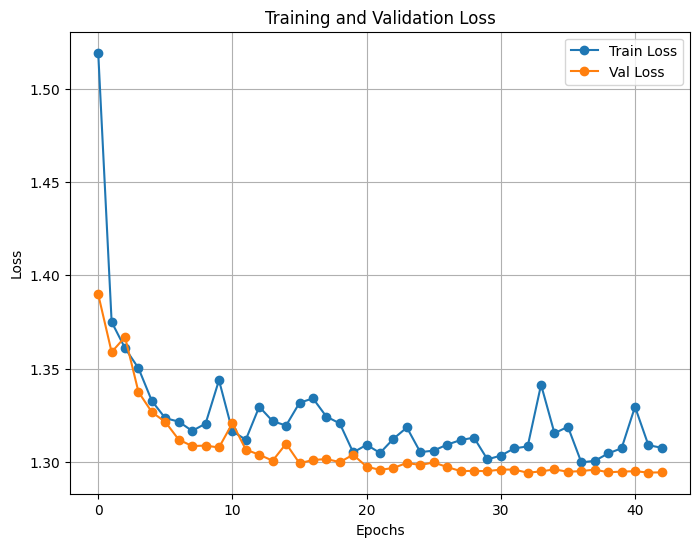

In [11]:
# # Start timing
# start_time = time.time()

# edge_index 由上面的 G.edges() 转成 (2, num_edges)
model = GNN_RNN_Model(
    gnn_in_channels=6,            # 每个节点是单通道（标量）
    gnn_out_channels=64,          # GCN 输出通道数

    rnn_type='RNN',              # 选择模型
    rnn_hidden_dims=[64, 128, 256, 128, 64, 1],   # 四层 LSTM
    rnn_dropout=0.1,              # 30% Dropout

    use_layernorm=False,           # 启用 LayerNorm
    fc_hidden_dim=6               # 预测单个数值（回归任务）
)


train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    edge_index_big,
    edge_weight_big,
    epochs=300,
    lr=0.0005,
    patience=10,           # 提前停止的耐心轮数
    lr_patience=3,         # 学习率调整的耐心轮数
    lr_factor=0.5,         # 学习率缩放因子
    min_lr=1e-6            # 学习率下限
)

# # End timing
# end_time = time.time()

# # Calculate and output the runtime
# elapsed_time = end_time - start_time
# print(f"operation time: {elapsed_time:.4f} sec")

In [12]:
torch.save(model, "/root/autodl-tmp/model/Antwerp_2020_march/Static_dtw_Gaussian_Model_RNN-Encoder-Decoder/full_model.pth")
# model = torch.load("/root/autodl-tmp/model/Static_Model_RNN-Encoder-Decoder/full_model.pth")
# model.eval()

y_true (first 200 values): [ 5.  0. 10.  2.  2.  0.  5.  0.  7.  0.  0.  3.  1.  2.  2.  6.  2.  1.
  4.  3.  4.  5.  2.  2.  7.  1. 15.  6.  1.  4.  6.  2.  0.  5.  2.  0.
 13.  6.  2.  2. 23.  3.  2.  0.  0.  1.  4.  4. 13.  4.  5.  7.  0.  5.
  1.  1.  6.  1.  4.  0.  4.  2.  1.  2.  4.  9.  3.  0.  2.  2.  4.  5.
  1.  4.  2.  1.  4.  3.  3.  5.  7.  0.  9.  3.  0.  0.  5.  4.  5.  3.
  0.  1.  2.  6.  0. 14.  4.  1.  1.  0.  7. 14.  5.  3.  2.  0.  2.  3.
  6.  1.  2.  0.  0.  0. 10.  3.  4.  2.  4.  0.  1.  2.  0.  4.  6.  5.
  1.  1.  4.  2.  3.  0.  0.  3.  5.  4.  0.  1.  1.  3.  4.  3.  7.  3.
  0.  1.  3.  0.  2.  5.  3.  5.  3.  4.  0.  3. 12.  1.  8.  3.  2.  2.
  3.  0.  2. 10.  3.  5.  2.  5.  2.  4.  3.  3.  2.  2.  2.  3.  1.  5.
  2.  6.  0.  0.  5.  1.  7.  2.  2.  3.  0.  6.  6.  8.  2.  5.  2.  1.
  2.  6.]
y_pred (first 200 values): [ 4.646624   4.641926   5.487946   2.4528384  2.7042377  4.7614965
  4.022581   1.7381644  3.4978874  1.7387495  1.7409105  3.4440324

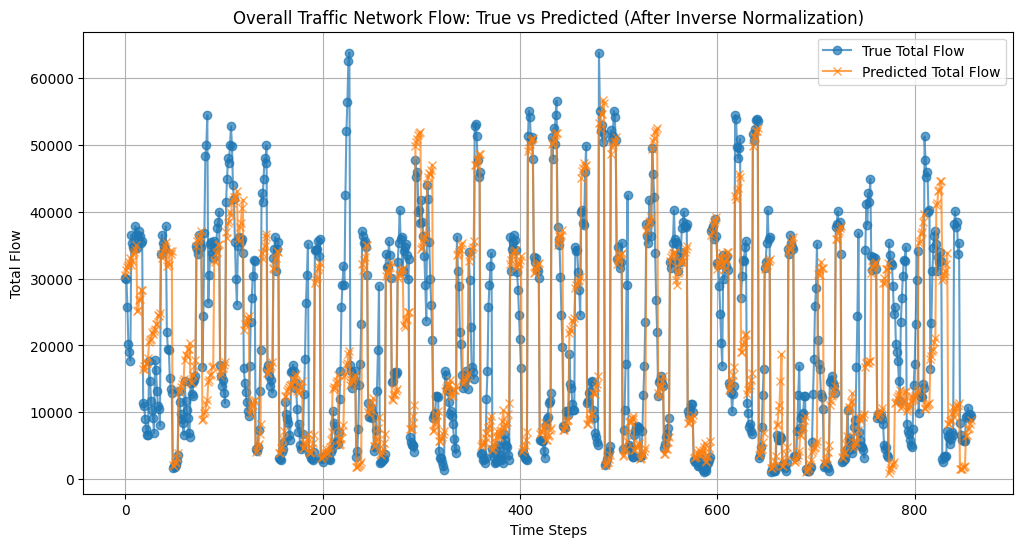

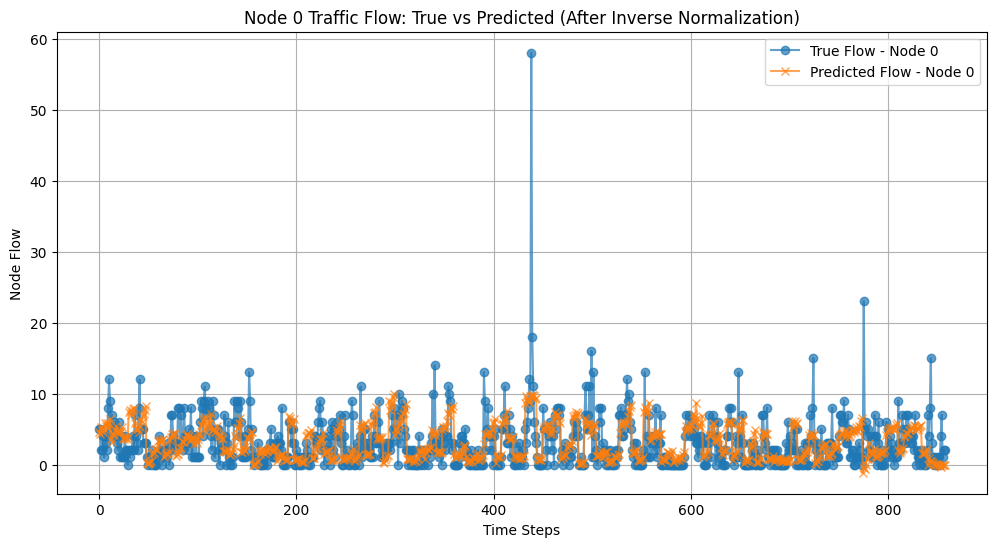

Visualization Complete!


In [13]:
# ============== 8. 测试集预测和真实值可视化 ==============

def inverse_zscore(normalized_tensor, mean_val, std_val):
    """
    对标准化后的张量进行反归一化。
    """
    return normalized_tensor * std_val + mean_val

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = np.finfo(np.float32).eps  # 防止除 0
    mask = y_true > 1e-6  # 过滤掉 y_true = 0 的数据
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(np.float32).eps)) * 100

def visualize_test_predictions(
    model, 
    test_loader, 
    edge_index_big,
    edge_weight_big,
    device, 
    test_norm_params
):
    model.eval()
    all_preds = []
    all_targets = []


    edge_index_big = edge_index_big.to(device)
    if edge_weight_big is not None:
        edge_weight_big = edge_weight_big.to(device)

    # 收集所有测试集的预测值和真实值
    with torch.no_grad():
        for batch_idx, (X_batch, Y_batch) in enumerate(test_loader):

            current_batch_size = X_batch.shape[0]  # 获取当前 batch 的实际大小

            # 如果 batch size 小于设定的 batch_size，重新计算 edge_index_big
            if current_batch_size != batch_size:
                edge_index_big, edge_weight_big = merge_graphs_into_batch(remapped_graphs, current_batch_size)
                edge_index_big = edge_index_big.to(device)
                edge_weight_big = edge_weight_big.to(device)
            
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # 预测值 (注意传入 edge_weight_single=edge_weight)
            test_preds = model(
               X_batch, edge_index_big = edge_index_big, edge_weight_big = edge_weight_big
            )  # => (B, T, N)

            # ========== 反归一化 ==========
            # 使用 test_norm_params 中记录的均值和标准差
            for i in range(X_batch.shape[0]):  # 遍历 batch 中的每个样本
                mean_val = test_norm_params[batch_idx * X_batch.shape[0] + i]['mean']
                std_val = test_norm_params[batch_idx * X_batch.shape[0] + i]['std']

                # 对预测值进行反归一化
                # 注意：先把 test_preds[i] 移到 cpu，再做 numpy 的操作 / 或者直接在 GPU 上进行逆标准化
                test_preds[i] = inverse_zscore(
                    test_preds[i].cpu(), 
                    mean_val, 
                    std_val
                )

            all_preds.append(test_preds.cpu())
            all_targets.append(Y_batch.cpu())

    # 拼接所有批次
    all_preds = torch.cat(all_preds, dim=0)     # (Total_samples, T, N)
    all_targets = torch.cat(all_targets, dim=0) # (Total_samples, T, N)

    # ================= 9. 计算指标（针对每个节点的损失） =================
    # 将预测值和真实值展平成 (samples * T * N,) 形状
    y_true = all_targets.flatten().numpy()
    y_pred = all_preds.flatten().numpy()
    print("y_true (first 200 values):", y_true[:200])
    print("y_pred (first 200 values):", y_pred[:200])


    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    # 打印结果
    print(f"\nEvaluation Metrics on Test Set (After Inverse Normalization) - Every Node :")
    print(f"  - MSE  (均方误差): {mse:.4f}")
    print(f"  - MAE  (平均绝对误差): {mae:.4f}")
    print(f"  - R^2  (决定系数): {r2:.4f}")
    print(f"  - MAPE (平均绝对百分比误差): {mape:.2f}%\n")
    print(f"  - SMAPE (对称平均绝对百分比误差): {smape:.2f}%\n")

    # ========== 计算整体网络的预测和真实值（节点求和）==========
    total_pred_flow = all_preds.sum(dim=2)      # (Total_samples, T)
    total_true_flow = all_targets.sum(dim=2)

    # ================= 计算整体损失指标 =================
    y_true = total_true_flow.flatten().numpy()
    y_pred = total_pred_flow.flatten().numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    print(f"\nEvaluation Metrics on Aggregated Traffic Network Flow (After Inverse Normalization) - Entire Network:")
    print(f"  - MSE  (均方误差): {mse:.4f}")
    print(f"  - MAE  (平均绝对误差): {mae:.4f}")
    print(f"  - R^2  (决定系数): {r2:.4f}")
    print(f"  - MAPE (平均绝对百分比误差): {mape:.2f}%\n")
    print(f"  - SMAPE (对称平均绝对百分比误差): {smape:.2f}%\n")

    # ============== 8.1 整个交通网的整体流量对比 ==============
    # 将每个时间步的所有节点流量求和 => (Total_samples, T)
    total_pred_flow = all_preds.sum(dim=2)      # 沿着节点维度求和
    total_true_flow = all_targets.sum(dim=2)

    # 绘制整体流量的对比图
    plt.figure(figsize=(12,6))
    plt.plot(total_true_flow.flatten(), label='True Total Flow', marker='o', alpha=0.7)
    plt.plot(total_pred_flow.flatten(), label='Predicted Total Flow', marker='x', alpha=0.7)
    plt.xlabel('Time Steps')
    plt.ylabel('Total Flow')
    plt.title('Overall Traffic Network Flow: True vs Predicted (After Inverse Normalization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig("/root/autodl-tmp/model/Antwerp_2020_march/Static_dtw_Gaussian_Model_RNN-Encoder-Decoder/Overall Traffic Network Flow: True vs Predicted (After Inverse Normalization).png")

    plt.close()

    # ============== 8.2 某个节点的流量对比 ==============
    # 选择一个节点（例如第2381号节点），可以改为任意节点索引
    node_idx = 0
    node_pred = all_preds[:, :, node_idx].flatten()  # 形状: (Total_samples * T,)
    node_true = all_targets[:, :, node_idx].flatten()

    # 绘制该节点的流量对比图
    plt.figure(figsize=(12,6))
    plt.plot(node_true, label=f'True Flow - Node {node_idx}', marker='o', alpha=0.7)
    plt.plot(node_pred, label=f'Predicted Flow - Node {node_idx}', marker='x', alpha=0.7)
    plt.xlabel('Time Steps')
    plt.ylabel('Node Flow')
    plt.title(f'Node {node_idx} Traffic Flow: True vs Predicted (After Inverse Normalization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig("/root/autodl-tmp/model/Antwerp_2020_march/Static_dtw_Gaussian_Model_RNN-Encoder-Decoder/Node 0 Traffic Flow: True vs Predicted (After Inverse Normalization).png")

    plt.close()

    print("Visualization Complete!")

    return all_preds, all_targets

# ============== 调用可视化函数 ==============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds, all_targets = visualize_test_predictions(
                         model, 
                         test_loader, 
                         edge_index_big,
                         edge_weight_big,
                         device, 
                         test_norm_params
                         )


In [14]:
# 获取测试集样本数量、时间步、节点数
num_samples, num_timesteps, num_nodes = all_preds.shape

# 存储每个节点的损失
node_metrics = []

for node_idx in range(num_nodes):
    # 获取该节点的真实值和预测值
    y_true_node = all_targets[:, :, node_idx].flatten().numpy()
    y_pred_node = all_preds[:, :, node_idx].flatten().numpy()

    # 计算误差指标
    mse_node = mean_squared_error(y_true_node, y_pred_node)
    mae_node = mean_absolute_error(y_true_node, y_pred_node)
    r2_node = r2_score(y_true_node, y_pred_node)
    mape_node = mean_absolute_percentage_error(y_true_node, y_pred_node)
    smape_node = symmetric_mean_absolute_percentage_error(y_true_node, y_pred_node)

    # 存储该节点的误差
    node_metrics.append({
        "Node": node_idx,
        "MSE": mse_node,
        "MAE": mae_node,
        "R2": r2_node,
        "MAPE": mape_node,
        "SMAPE": smape_node
    })

# 将数据转换为 Pandas DataFrame
df_node_metrics = pd.DataFrame(node_metrics)

# 保存到 CSV 文件
df_node_metrics.to_csv("node_losses.csv", index=False)

print("\n✅ 每个节点的损失已计算并保存到 node_losses.csv！")



✅ 每个节点的损失已计算并保存到 node_losses.csv！
